In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D

In [2]:
df = pd.read_csv('./Fog.csv')
df.drop(df.index[df[(df.values == 'X') | \
    (df.values == 'V')].index], inplace=True)
df = df.drop(['time','Label'],axis=1)
df = df.astype("float64")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19659 entries, 0 to 19679
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    19659 non-null  float64
 1   dpTemp  19659 non-null  float64
 2   RH      19659 non-null  float64
 3   WDIR    19659 non-null  float64
 4   VIZ     19659 non-null  float64
dtypes: float64(5)
memory usage: 921.5 KB


In [3]:
df.corr()['VIZ']

temp      0.328069
dpTemp    0.075895
RH       -0.436874
WDIR     -0.102396
VIZ       1.000000
Name: VIZ, dtype: float64

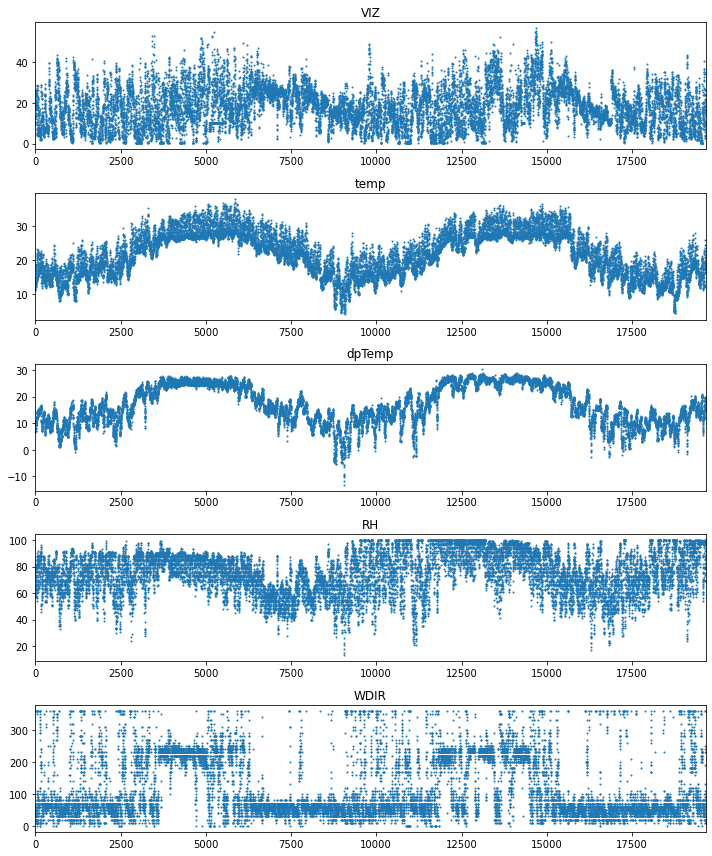

In [4]:
fig = plt.figure(figsize=(10, 12))

names = ('VIZ', 'temp', 'dpTemp', 'RH', 'WDIR')

for i in range(5):
    data = df[names[i]]
    ax = fig.add_subplot(5, 1, i + 1)
    plt.scatter(np.arange(data.size), data, s=1)
    ax.set_xlim([0, data.size])
    ax.set_title(names[i])

plt.tight_layout()
plt.show()

In [5]:
# dataset = df.drop(['VIZ'], axis=1)
dataset = df.astype('float32')
dataset

,temp,dpTemp,RH,WDIR,VIZ
0,11.400000,6.700000,73.0,60.0,10.510000
1,11.300000,6.800000,74.0,50.0,9.940000
2,11.400000,6.900000,74.0,30.0,9.890000
3,11.300000,6.800000,74.0,40.0,10.410000
4,11.500000,7.000000,74.0,50.0,11.990000
...,...,...,...,...,...
19675,18.799999,18.799999,100.0,60.0,16.790001
19676,18.700001,18.200001,97.0,40.0,18.520000
19677,18.799999,18.299999,97.0,30.0,20.629999
19678,18.600000,18.299999,98.0,10.0,15.930000


In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))  # Also try QuantileTransformer
scalered = scaler.fit_transform(dataset)

scalerY = MinMaxScaler(feature_range=(0, 1))
Y = scalerY.fit_transform(dataset['VIZ'].values.reshape(-1, 1))
scalered.shape, Y.shape

((19659, 5), (19659, 1))

In [22]:
split = 0.2
slice_index = int(scalered.shape[0] * (1 - split))

train, test = scalered[:slice_index, :], scalered[slice_index:, :]
train.shape, test.shape, slice_index

((15727, 5), (3932, 5), 15727)

In [23]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        # print(dataset[i], dataset[i+seq_size, -1])
        window = dataset[i:(i+seq_size), :-1]
        x.append(window)
        y.append(dataset[i+seq_size, -1])

    return np.array(x), np.array(y)


In [10]:
lookback = 72

trainX, trainY = to_sequences(train, lookback)
testX, testY = to_sequences(test, lookback)

In [24]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((15654, 1, 288), (15654,), (3859, 1, 288), (3859,))

In [72]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, -1))
testX = np.reshape(testX, (testX.shape[0], 1, -1))

print('Single LSTM with hidden Dense...')
model = Sequential()
model.add(LSTM(128, input_shape=(None, lookback*4)))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20,
#                        verbose=1, mode='auto', restore_best_weights=True)
model.summary()


Single LSTM with hidden Dense...
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 128)               213504    
                                                                 
 dense_12 (Dense)            (None, 32)                4128      
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 217,665
Trainable params: 217,665
Non-trainable params: 0
_________________________________________________________________


In [73]:
history = model.fit(trainX, trainY, validation_data=(testX, testY),
                    verbose=2, epochs=100)

Epoch 1/100
490/490 - 6s - loss: 107.8390 - val_loss: 68.1191 - 6s/epoch - 12ms/step
Epoch 2/100
490/490 - 3s - loss: 98.5724 - val_loss: 68.9095 - 3s/epoch - 7ms/step
Epoch 3/100
490/490 - 3s - loss: 98.2248 - val_loss: 59.4001 - 3s/epoch - 7ms/step
Epoch 4/100
490/490 - 3s - loss: 95.1611 - val_loss: 63.9797 - 3s/epoch - 6ms/step
Epoch 5/100
490/490 - 3s - loss: 92.7817 - val_loss: 63.1902 - 3s/epoch - 5ms/step
Epoch 6/100
490/490 - 3s - loss: 93.6377 - val_loss: 59.2032 - 3s/epoch - 5ms/step
Epoch 7/100
490/490 - 3s - loss: 94.8938 - val_loss: 64.5428 - 3s/epoch - 5ms/step
Epoch 8/100
490/490 - 3s - loss: 92.1161 - val_loss: 74.3316 - 3s/epoch - 5ms/step
Epoch 9/100
490/490 - 3s - loss: 90.0077 - val_loss: 63.3029 - 3s/epoch - 5ms/step
Epoch 10/100
490/490 - 3s - loss: 90.0880 - val_loss: 66.0976 - 3s/epoch - 5ms/step
Epoch 11/100
490/490 - 3s - loss: 91.0602 - val_loss: 71.3067 - 3s/epoch - 5ms/step
Epoch 12/100
490/490 - 3s - loss: 90.6173 - val_loss: 64.9259 - 3s/epoch - 5ms/step

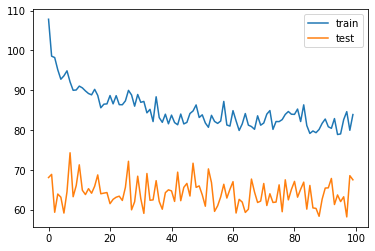

In [74]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [75]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict.shape, testPredict.shape

((15654, 1), (3859, 1))

In [76]:
trainY.shape, testY.shape

((15654,), (3859,))

In [77]:
trainPredict = scalerY.inverse_transform(trainPredict)
invTrainY = scalerY.inverse_transform([trainY])
testPredict = scalerY.inverse_transform(testPredict)
invTestY = scalerY.inverse_transform([testY])
trainPredict.shape, invTrainY.shape, testPredict.shape, invTestY.shape


((15654, 1), (1, 15654), (3859, 1), (1, 3859))

In [78]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(invTrainY[0], trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(invTestY[0], testPredict))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 516.32 RMSE
Test Score: 467.07 RMSE


In [79]:
trainPredictPlot = np.empty_like(dataset.values[:, 0].reshape(-1, 1))
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(trainPredict)+lookback, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset.values[:, 0].reshape(-1, 1))
testPredictPlot[:, :] = np.nan
testPredictPlot[-len(testPredict):, :] = testPredict


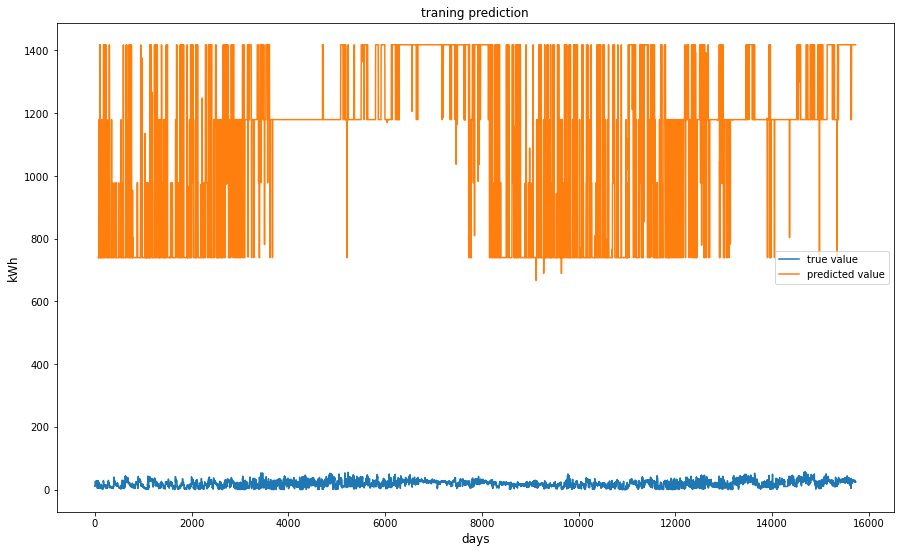

In [80]:
plt.figure(figsize=(15, 9))
plt.title('traning prediction', fontsize=12)
plt.ylabel('kWh', fontsize=12)
plt.xlabel('days', fontsize=12)
plt.plot(dataset.values[:slice_index, 4], label='true value')
plt.plot(trainPredictPlot[:slice_index], label='predicted value')
plt.legend()
plt.show()


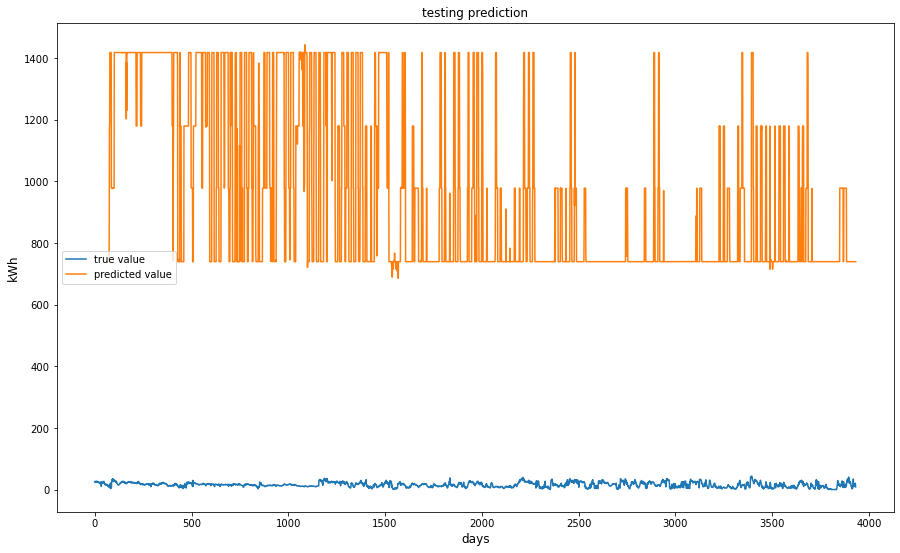

In [81]:
plt.figure(figsize=(15, 9))
plt.title('testing prediction', fontsize=12)
plt.ylabel('kWh', fontsize=12)
plt.xlabel('days', fontsize=12)
plt.plot(dataset.values[slice_index:, 4], label='true value')
plt.plot(testPredictPlot[slice_index:], label='predicted value')
plt.legend()
plt.show()
